# 第4章 予測

In [1]:
ENV["LINES"] = 10
ENV["COLUMNS"] = 1000

1000

In [2]:
using DataFrames, DataFramesMeta, CSV, Statistics, Gadfly, Dates, GLM, StatsBase, CategoricalArrays

## 4.1 選挙結果の予測

In [3]:
pres08_df = CSV.read("../../data/PREDICTION/pres08.csv", DataFrame, missingstring=["NA"])
polls08_df = CSV.read("../../data/PREDICTION/polls08.csv", DataFrame, missingstring=["NA"])

,state,Pollster,Obama,McCain,middate
,String3,String31,Int64,Int64,Date
1,AL,SurveyUSA-2,36,61,2008-10-27
2,AL,Capital Survey-2,34,54,2008-10-15
3,AL,SurveyUSA-2,35,62,2008-10-08
4,AL,Capital Survey-2,35,55,2008-10-06
5,AL,Rasmussen-1,39,60,2008-09-22
6,AL,SurveyUSA-2,34,64,2008-09-16
7,AL,ARG-4,36,58,2008-09-14
8,AL,U. of South Alabama-8,25,52,2008-09-11
9,AL,Capital Survey-7,35,55,2008-09-06


In [4]:
@rtransform!(pres08_df, :margin = :Obama - :McCain)
@rtransform!(polls08_df, :margin = :Obama - :McCain)

,state,Pollster,Obama,McCain,middate,margin
,String3,String31,Int64,Int64,Date,Int64
1,AL,SurveyUSA-2,36,61,2008-10-27,-25
2,AL,Capital Survey-2,34,54,2008-10-15,-20
3,AL,SurveyUSA-2,35,62,2008-10-08,-27
4,AL,Capital Survey-2,35,55,2008-10-06,-20
5,AL,Rasmussen-1,39,60,2008-09-22,-21
6,AL,SurveyUSA-2,34,64,2008-09-16,-30
7,AL,ARG-4,36,58,2008-09-14,-22
8,AL,U. of South Alabama-8,25,52,2008-09-11,-27
9,AL,Capital Survey-7,35,55,2008-09-06,-20


In [5]:
diff_df = @chain polls08_df begin
    groupby(:state)
    @subset(:middate .== maximum(:middate))
    groupby(:state)
    @combine(:pred_margin_mean = mean(:margin))
    innerjoin(pres08_df, on=:state)
    @select(:state, :margin, :pred_margin_mean, :EV)
    @rtransform(:diff = :margin - :pred_margin_mean)
end
mean(diff_df.diff)

1.0620915032679739

In [6]:
sqrt(mean(diff_df.diff .^ 2))

5.908940458495747

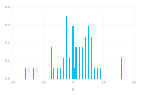

In [7]:
plot(x = diff_df.diff, Geom.histogram(density=true))

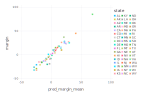

In [8]:
plot(diff_df, x = :pred_margin_mean, y = :margin, color = :state, Geom.point)

In [9]:
@rtransform!(diff_df, :is_miss = sign(:margin) != sign(:pred_margin_mean))
@rsubset(diff_df, :is_miss == true)

,state,margin,pred_margin_mean,EV,diff,is_miss
,String3,Int64,Float64,Int64,Float64,Bool
1,IN,1,-5.0,11,6.0,1
2,MO,-1,1.0,11,-2.0,1
3,NC,1,-1.0,15,2.0,1


In [10]:
sum(@rsubset(diff_df, :margin > 0).EV)

364

In [11]:
sum(@rsubset(diff_df, :pred_margin_mean > 0).EV)

349

In [12]:
pollsUS08_df = CSV.read("../../data/PREDICTION/pollsUS08.csv", DataFrame, missingstring=["NA"])

,Pollster,McCain,Obama,middate
,String,Int64,Int64,Date
1,IBD/TIPP,48,36,2007-07-04
2,GWU (Lake/Tarrance),51,39,2007-07-11
3,Diageo/Hotline,43,38,2007-07-14
4,Newsweek,44,46,2007-07-19
5,Rasmussen,44,47,2007-07-19
6,ABC/Post,45,47,2007-07-19
7,Time,49,42,2007-07-24
8,Newsweek,42,48,2007-07-26
9,Rasmussen,44,44,2007-08-09


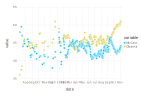

In [13]:
unique_dates = unique(pollsUS08_df.middate)
sort!(unique_dates)
result_df = DataFrame()
for date_i in unique_dates
    from_date = date_i + Dates.Day(-7)
    to_date = date_i
    tmp_df = @chain pollsUS08_df begin
        @rsubset(from_date <= :middate <= to_date)
        @combine begin
            :McCain = mean(:McCain)
            :Obama = mean(:Obama)
        end
    end
    insertcols!(tmp_df, 1, :date => date_i)
    append!(result_df, tmp_df)
end
@chain result_df begin
    stack
    plot(x = :date, y = :value, color = :variable, Geom.point)
end

## 4.2 線形回帰

In [14]:
face_df = CSV.read("../../data/PREDICTION/face.csv", DataFrame, missingstring=["NA"])

,year,state,winner,loser,w.party,l.party,d.comp,r.comp,d.votes,r.votes
,Int64,String3,String15,String15,String1,String1,Float64,Float64,Int64,Int64
1,2000,CA,Feinstein,Campbell,D,R,0.564568,0.435432,5790154,3779325
2,2000,DE,Carper,Roth,D,R,0.341912,0.658088,181387,142683
3,2000,FL,Nelson,McCollum,D,R,0.612368,0.387632,2987644,2703608
4,2000,GA,Miller,Mattingly,D,R,0.541533,0.458467,1390428,933698
5,2000,HI,Akaka,Carroll,D,R,0.680232,0.319768,251130,84657
6,2000,IN,Lugar,Johnson,R,D,0.320502,0.679498,684242,1419629
7,2000,MA,Kennedy,Robinson,D,R,0.403756,0.596244,1877439,334721
8,2000,MD,Sarbanes,Rappaport,D,R,0.603015,0.396985,1171151,678376
9,2000,ME,Snowe,Lawrence,R,D,0.538573,0.461427,197742,431727


In [15]:
face_df = @chain face_df begin
    rename("d.votes" => :d_votes, "r.votes" => :r_votes)
    @rtransform begin
        @astable begin
            sum_votes = :d_votes + :r_votes
            :d_share = :d_votes / sum_votes
            :r_share = :r_votes / sum_votes
            :diff_share = :d_share - :r_share
        end
    end
end

,year,state,winner,loser,w.party,l.party,d.comp,r.comp,d_votes,r_votes,d_share,r_share,diff_share
,Int64,String3,String15,String15,String1,String1,Float64,Float64,Int64,Int64,Float64,Float64,Float64
1,2000,CA,Feinstein,Campbell,D,R,0.564568,0.435432,5790154,3779325,0.605065,0.394935,0.210129
2,2000,DE,Carper,Roth,D,R,0.341912,0.658088,181387,142683,0.559715,0.440285,0.119431
3,2000,FL,Nelson,McCollum,D,R,0.612368,0.387632,2987644,2703608,0.524954,0.475046,0.0499075
4,2000,GA,Miller,Mattingly,D,R,0.541533,0.458467,1390428,933698,0.598258,0.401742,0.196517
5,2000,HI,Akaka,Carroll,D,R,0.680232,0.319768,251130,84657,0.747885,0.252115,0.49577
6,2000,IN,Lugar,Johnson,R,D,0.320502,0.679498,684242,1419629,0.32523,0.67477,-0.34954
7,2000,MA,Kennedy,Robinson,D,R,0.403756,0.596244,1877439,334721,0.84869,0.15131,0.697381
8,2000,MD,Sarbanes,Rappaport,D,R,0.603015,0.396985,1171151,678376,0.633216,0.366784,0.266433
9,2000,ME,Snowe,Lawrence,R,D,0.538573,0.461427,197742,431727,0.314141,0.685859,-0.371718


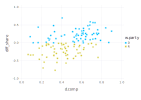

In [16]:
plot(face_df, x = Symbol("d.comp"), y = :diff_share, color = Symbol("w.party"), Geom.point)

In [17]:
cor(face_df[!, "d.comp"], face_df.diff_share)

0.4327743457276102

In [18]:
face_df = rename(face_df, "d.comp" => :d_comp, "r.comp" => :r_comp)
model = lm(@formula(diff_share ~ d_comp), face_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

diff_share ~ 1 + d_comp

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.312226   0.0659623  -4.73    <1e-05  -0.442861  -0.181591
d_comp        0.660381   0.127177    5.19    <1e-06   0.408515   0.912248
─────────────────────────────────────────────────────────────────────────

In [19]:
coeftable(model) |> DataFrame

,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),-0.312226,0.0659623,-4.7334,6.23903e-6,-0.442861,-0.181591
2,d_comp,0.660381,0.127177,5.19263,8.85436e-7,0.408515,0.912248


In [20]:
coef(model)

2-element Vector{Float64}:
 -0.31222587527907475
  0.6603814567765847

In [21]:
fitted(model)

119-element Vector{Float64}:
  0.06060410678236289
 -0.08643340185529508
  0.09217061249344383
  ⋮
  0.06668151808330294
 -0.14713051108492858

In [22]:
ssr = sum((face_df.diff_share .- fitted(model)).^2)

8.308663784729214

In [23]:
rmse = sqrt(ssr / size(face_df)[1])

0.2642360764039512

In [24]:
pres12_df = CSV.read("../../data/PREDICTION/pres12.csv", DataFrame, missingstring=["NA"])

,state,Obama,Romney,EV
,String3,Int64,Int64,Int64
1,AL,38,61,9
2,AK,41,55,3
3,AZ,45,54,11
4,AR,37,61,6
5,CA,60,37,55
6,CO,51,46,9
7,CT,58,41,7
8,DE,59,40,3
9,DC,91,7,3


In [25]:
describe(pres12_df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,state,,AK,,WY,0,String3
2,Obama,49.0588,25,51.0,91,0,Int64
3,Romney,49.0392,7,48.0,73,0,Int64
4,EV,10.549,3,8.0,55,0,Int64


In [26]:
pres_df = innerjoin(pres08_df, pres12_df; on = :state, renamecols=(:_08 => :_12))

,state.name_08,state,Obama_08,McCain_08,EV_08,margin_08,Obama_12,Romney_12,EV_12
,String15,String3,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Alabama,AL,39,60,9,-21,38,61,9
2,Alaska,AK,38,59,3,-21,41,55,3
3,Arizona,AZ,45,54,10,-9,45,54,11
4,Arkansas,AR,39,59,6,-20,37,61,6
5,California,CA,61,37,55,24,60,37,55
6,Colorado,CO,54,45,9,9,51,46,9
7,Connecticut,CT,61,38,7,23,58,41,7
8,Delaware,DE,62,37,3,25,59,40,3
9,D.C.,DC,92,7,3,85,91,7,3


In [27]:
describe(pres_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,DataType
1,state.name_08,,,Alabama,,,,Wyoming,51,0,Alabama,Wyoming,String15
2,state,,,AK,,,,WY,51,0,AL,WY,String3
3,Obama_08,51.3725,11.0399,33,43.0,51.0,57.5,92,,0,39,33,Int64
4,McCain_08,47.0588,11.0425,7,40.0,47.0,56.0,66,,0,60,65,Int64
5,EV_08,10.549,9.58189,3,4.5,8.0,11.5,55,,0,9,3,Int64
6,margin_08,4.31373,22.0703,-32,-13.0,4.0,17.5,85,,0,-21,-32,Int64
7,Obama_12,49.0588,11.8041,25,40.5,51.0,56.0,91,,0,38,28,Int64
8,Romney_12,49.0392,11.7864,7,41.0,48.0,58.0,73,,0,61,69,Int64
9,EV_12,10.549,9.68569,3,4.5,8.0,11.5,55,,0,9,3,Int64


In [28]:
pres_df = @chain pres_df begin
    @transform begin
        :Obama_08_z = zscore(:Obama_08)
        :Obama_12_z = zscore(:Obama_12)
    end
end

,state.name_08,state,Obama_08,McCain_08,EV_08,margin_08,Obama_12,Romney_12,EV_12,Obama_08_z,Obama_12_z
,String15,String3,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,Alabama,AL,39,60,9,-21,38,61,9,-1.12072,-0.936864
2,Alaska,AK,38,59,3,-21,41,55,3,-1.2113,-0.682715
3,Arizona,AZ,45,54,10,-9,45,54,11,-0.577231,-0.343849
4,Arkansas,AR,39,59,6,-20,37,61,6,-1.12072,-1.02158
5,California,CA,61,37,55,24,60,37,55,0.872063,0.926897
6,Colorado,CO,54,45,9,9,51,46,9,0.237997,0.16445
7,Connecticut,CT,61,38,7,23,58,41,7,0.872063,0.757464
8,Delaware,DE,62,37,3,25,59,40,3,0.962644,0.842181
9,D.C.,DC,92,7,3,85,91,7,3,3.68007,3.55311


In [29]:
model = lm(@formula(Obama_12_z ~ Obama_08_z), pres_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Obama_12_z ~ 1 + Obama_08_z

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -1.24214e-16   0.0256341  -0.00    1.0000  -0.0515136  0.0515136
Obama_08_z    0.983442      0.0258891  37.99    <1e-37   0.931416   1.03547
─────────────────────────────────────────────────────────────────────────────

In [30]:
@chain pres_df begin
    @subset(:Obama_08 .<= quantile!(:Obama_08, 0.25))
    @rtransform(:is_large = :Obama_12_z > :Obama_08_z)
    @combine(:res = mean(:is_large))
end

,res
,Float64
1,0.571429


In [31]:
@chain pres_df begin
    @subset(:Obama_08 .>= quantile!(:Obama_08, 0.75))
    @rtransform(:is_large = :Obama_12_z > :Obama_08_z)
    @combine(:res = mean(:is_large))
end

,res
,Float64
1,0.307692


In [32]:
florida_df = CSV.read("../../data/PREDICTION/florida.csv", DataFrame, missingstring=["NA"])

,county,Clinton96,Dole96,Perot96,Bush00,Gore00,Buchanan00
,String15,Int64,Int64,Int64,Int64,Int64,Int64
1,Alachua,40144,25303,8072,34124,47365,263
2,Baker,2273,3684,667,5610,2392,73
3,Bay,17020,28290,5922,38637,18850,248
4,Bradford,3356,4038,819,5414,3075,65
5,Brevard,80416,87980,25249,115185,97318,570
6,Broward,320736,142834,38964,177323,386561,788
7,Calhoun,1794,1717,630,2873,2155,90
8,Charlotte,27121,27836,7783,35426,29645,182
9,Citrus,22042,20114,7244,29765,25525,270


In [33]:
describe(florida_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,DataType
1,county,,,Alachua,,,,Washington,67,0,Alachua,Washington,String15
2,Clinton96,37999.5,66009.8,829,3136.5,13246.0,38956.0,320736,,0,40144,2992,Int64
3,Dole96,33482.4,44743.1,913,3343.5,15608.0,41993.5,209634,,0,25303,3522,Int64
4,Perot96,7220.54,8972.96,316,1072.5,3739.0,8700.0,38964,,0,8072,1287,Int64
5,Bush00,43434.0,57154.2,1317,4757.0,20206.0,56546.5,289492,,0,34124,4994,Int64
6,Gore00,43419.7,74950.6,789,3058.0,14167.0,46015.0,386561,,0,47365,2798,Int64
7,Buchanan00,260.672,449.924,9,46.5,120.0,285.5,3407,,0,263,88,Int64


In [34]:
model = lm(@formula(Buchanan00 ~ Perot96), florida_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Buchanan00 ~ 1 + Perot96

Coefficients:
────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error     t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  1.34575   49.7593      0.03    0.9785  -98.0304     100.722
Perot96      0.035915   0.00434007  8.28    <1e-11    0.0272473    0.0445828
────────────────────────────────────────────────────────────────────────────

In [35]:
TSS = sum((florida_df.Buchanan00 .- mean(florida_df.Buchanan00)) .^ 2)

1.3360498776119404e7

In [36]:
SSR = sum((florida_df.Buchanan00 .- predict(model)) .^ 2)

6.506117658591911e6

In [37]:
Rsq = 1 - SSR / TSS

0.5130333255057089

In [38]:
r2(model)

0.5130333255057089

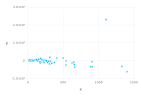

In [39]:
plot(x = predict(model), y = florida_df.Buchanan00 - predict(model), Geom.point)

In [40]:
florida_df.county[florida_df.Buchanan00 .- predict(model) .== maximum(florida_df.Buchanan00 .- predict(model))]

1-element Vector{String15}:
 "PalmBeach"

In [41]:
florida_masked_df = @chain florida_df begin
    @rsubset(:county != "PalmBeach")
end
model = lm(@formula(Buchanan00 ~ Perot96), florida_masked_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Buchanan00 ~ 1 + Perot96

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  45.8419     13.8927       3.30    0.0016  18.088      73.5959
Perot96       0.0243522   0.00127288  19.13    <1e-27   0.0218093   0.026895
────────────────────────────────────────────────────────────────────────────

In [42]:
r2(model)

0.8511674585300796

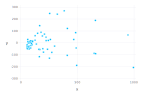

In [43]:
plot(x = predict(model), y = florida_masked_df.Buchanan00 - predict(model), Geom.point)

## 4.3 回帰分析と因果関係

In [44]:
women_df = CSV.read("../../data/PREDICTION/women.csv", DataFrame, missingstring=["NA"])

,GP,village,reserved,female,irrigation,water
,Int64,Int64,Int64,Int64,Int64,Int64
1,1,2,1,1,0,10
2,1,1,1,1,5,0
3,2,2,1,1,2,2
4,2,1,1,1,4,31
5,3,2,0,0,0,0
6,3,1,0,0,0,0
7,4,2,0,0,4,7
8,4,1,0,0,0,12
9,5,2,0,0,0,28


In [45]:
describe(women_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Nothing,Int64,Int64,Int64,DataType
1,GP,81.0,46.5481,1,41.0,81.0,121.0,161,,0,1,161,Int64
2,village,1.5,0.500778,1,1.0,1.5,2.0,2,,0,2,1,Int64
3,reserved,0.335404,0.472866,0,0.0,0.0,1.0,1,,0,1,0,Int64
4,female,0.385093,0.487375,0,0.0,0.0,1.0,1,,0,1,0,Int64
5,irrigation,3.26398,9.49251,0,0.0,0.0,2.0,90,,0,0,0,Int64
6,water,17.8416,33.6789,0,3.0,9.0,20.0,340,,0,10,11,Int64


In [46]:
@chain women_df begin
    groupby(:reserved)
    @combine(:ratio = mean(:female))
end

,reserved,ratio
,Int64,Float64
1,0,0.0747664
2,1,1.0


In [47]:
mean(women_df.water[women_df.reserved .== 1]) - mean(women_df.water[women_df.reserved .== 0])

9.252422983731394

In [48]:
mean(women_df.irrigation[women_df.reserved .== 1]) - mean(women_df.irrigation[women_df.reserved .== 0])

-0.369331948771201

In [49]:
model = lm(@formula(water ~ reserved), women_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

water ~ 1 + reserved

Coefficients:
───────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  14.7383      2.2863   6.45    <1e-09   10.2402     19.2364
reserved      9.25242     3.94775  2.34    0.0197    1.48561    17.0192
───────────────────────────────────────────────────────────────────────

In [50]:
model = lm(@formula(irrigation ~ reserved), women_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

irrigation ~ 1 + reserved

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   3.38785     0.649797   5.21    <1e-06    2.10944    4.66627
reserved     -0.369332    1.122     -0.33    0.7422   -2.57677    1.8381
─────────────────────────────────────────────────────────────────────────

In [51]:
social_df = CSV.read("../../data/CAUSALITY/social.csv", DataFrame, missingstring=["NA"])

,sex,yearofbirth,primary2004,messages,primary2006,hhsize
,String7,Int64,Int64,String15,Int64,Int64
1,male,1941,0,Civic Duty,0,2
2,female,1947,0,Civic Duty,0,2
3,male,1951,0,Hawthorne,1,3
4,female,1950,0,Hawthorne,1,3
5,female,1982,0,Hawthorne,1,3
6,male,1981,0,Control,0,3
7,female,1959,0,Control,1,3
8,male,1956,0,Control,1,3
9,female,1968,0,Control,0,2


In [52]:
describe(social_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,DataType
1,sex,,,female,,,,male,2,0,male,female,String7
2,yearofbirth,1956.21,14.4533,1900,1947.0,1956.0,1965.0,1986,,0,1941,1949,Int64
3,primary2004,0.401378,0.490178,0,0.0,0.0,1.0,1,,0,0,1,Int64
4,messages,,,Civic Duty,,,,Neighbors,4,0,Civic Duty,Control,String15
5,primary2006,0.312245,0.46341,0,0.0,0.0,1.0,1,,0,0,1,Int64
6,hhsize,2.18442,0.791746,1,2.0,2.0,2.0,8,,0,2,2,Int64


In [53]:
@transform!(social_df, :messages = categorical(:messages))

,sex,yearofbirth,primary2004,messages,primary2006,hhsize
,String7,Int64,Int64,Cat…,Int64,Int64
1,male,1941,0,Civic Duty,0,2
2,female,1947,0,Civic Duty,0,2
3,male,1951,0,Hawthorne,1,3
4,female,1950,0,Hawthorne,1,3
5,female,1982,0,Hawthorne,1,3
6,male,1981,0,Control,0,3
7,female,1959,0,Control,1,3
8,male,1956,0,Control,1,3
9,female,1968,0,Control,0,2


In [54]:
model = lm(@formula(primary2006 ~ messages), social_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

primary2006 ~ 1 + messages

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)           0.314538    0.00236657  132.91    <1e-99   0.309899     0.319176
messages: Control    -0.0178993   0.00259227   -6.90    <1e-11  -0.0229801   -0.0128186
messages: Hawthorne   0.00783697  0.00334714    2.34    0.0192   0.00127666   0.0143973
messages: Neighbors   0.0634106   0.00334721   18.94    <1e-79   0.0568501    0.069971
───────────────────────────────────────────────────────────────────────────────────────

In [55]:
@chain social_df begin
    groupby(:messages)
    @combine :m = mean(:primary2006)
end

,messages,m
,Cat…,Float64
1,Civic Duty,0.314538
2,Control,0.296638
3,Hawthorne,0.322375
4,Neighbors,0.377948


In [56]:
r2(model)

0.0032825640183636873

In [57]:
adjr2(model)

0.003272787869943894

In [68]:
@chain social_df begin
    @rsubset(:messages in ["Neighbors", "Control"])
    groupby([:primary2004, :messages])
    @combine(:m = mean(:primary2006))
    unstack(:primary2004, :messages, :m)
    @rtransform(:diff = :Neighbors - :Control)
end

,primary2004,Control,Neighbors,diff
,Int64,Float64?,Float64?,Float64
1,0,0.23711,0.306406,0.0692962
2,1,0.385805,0.48233,0.0965253


In [59]:
# model = lm(@formula(primary2006 ~ primary2004 + messages + primary2004*messages), social_df)
model = lm(@formula(primary2006 ~ primary2004*messages), social_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

primary2006 ~ 1 + primary2004 + messages + primary2004 & messages

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                         0.255403     0.00301349  84.75    <1e-99   0.249496     0.261309
primary2004                         0.148043     0.00476806  31.05    <1e-99   0.138698     0.157388
messages: Control                  -0.0182927    0.0033013   -5.54    <1e-07  -0.0247631   -0.0118222
messages: Hawthorne                 0.00500358   0.00426886   1.17    0.2412  -0.00336328   0.0133704
messages: Neig

In [63]:
model = lm(@formula(primary2006 ~ -1 + primary2004*messages), social_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

primary2006 ~ 0 + primary2004 + messages + primary2004 & messages

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)    Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
primary2004                        0.148043     0.00476806   31.05    <1e-99   0.138698    0.157388
messages: Civic Duty               0.255403     0.00301349   84.75    <1e-99   0.249496    0.261309
messages: Control                  0.23711      0.00134814  175.88    <1e-99   0.234468    0.239752
messages: Hawthorne                0.260406     0.00302359   86.12    <1e-99   0.25448     0.266332
messages: Neighbors    

In [70]:
@rtransform!(social_df, :age = 2006 - :yearofbirth)
social_neighbors_df = @rsubset(social_df, :messages in ["Control", "Neighbors"])
model = lm(@formula(primary2006 ~ age * messages), social_neighbors_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

primary2006 ~ 1 + age + messages + age & messages

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.   Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                0.0974733    0.00376029   25.92    <1e-99  0.0901032    0.104843
age                        0.00399821   7.2504e-5    55.14    <1e-99  0.0038561    0.00414032
messages: Neighbors        0.0498294    0.00915192    5.44    <1e-07  0.0318919    0.067767
age & messages: Neighbors  0.000628308  0.000176243   3.57    0.0004  0.000282876  0.00097374
────────────────────────────────────────────────────────────────────────────────────────

In [81]:
neighbors_df = DataFrame(:age => collect(25:20:85))
insertcols!(neighbors_df, 2, :messages => "Neighbors")
control_df = DataFrame(:age => collect(25:20:85))
insertcols!(control_df, 2, :messages => "Control")

,age,messages
,Int64,String
1,25,Control
2,45,Control
3,65,Control
4,85,Control


In [82]:
result_df = DataFrame(
    :age => collect(25:20:85),
    :neighbors => predict(model, neighbors_df),
    :control => predict(model, control_df),
)
@rtransform!(result_df, :effect = :neighbors - :control)

,age,neighbors,control,effect
,Int64,Float64?,Float64?,Float64
1,25,0.262966,0.197429,0.0655371
2,45,0.355496,0.277393,0.0781033
3,65,0.448026,0.357357,0.0906694
4,85,0.540557,0.437321,0.103236


In [84]:
model = lm(@formula(primary2006 ~ age * messages + (age ^ 2) * messages), social_neighbors_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

primary2006 ~ 1 + age + messages + :(age ^ 2) + age & messages + :(age ^ 2) & messages

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                     Coef.   Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    -0.0738458   0.00916406    -8.06    <1e-15  -0.0918071   -0.0558844
age                             0.0114271   0.000369644   30.91    <1e-99   0.0107026    0.0121516
messages: Neighbors            -0.043302    0.0223156     -1.94    0.0523  -0.08704      0.000435958
age ^ 2                        -7.38862e-5  3.6052e-6    -20.49    <1e-92  -8.09522e-5  -6.68201e-5
age

In [85]:
neighbors_df = DataFrame(:age => collect(25:85))
insertcols!(neighbors_df, 2, :messages => "Neighbors")
control_df = DataFrame(:age => collect(25:85))
insertcols!(control_df, 2, :messages => "Control")

result_df = DataFrame(
    :age => collect(25:85),
    :neighbors => predict(model, neighbors_df),
    :control => predict(model, control_df),
)
@rtransform!(result_df, :effect = :neighbors - :control)

,age,neighbors,control,effect
,Int64,Float64?,Float64?,Float64
1,25,0.213743,0.165652,0.0480911
2,26,0.224028,0.173311,0.0507171
3,27,0.234086,0.180822,0.0532638
4,28,0.243917,0.188185,0.0557313
5,29,0.253521,0.195401,0.0581196
6,30,0.262897,0.202469,0.0604287
7,31,0.272047,0.209389,0.0626585
8,32,0.28097,0.216161,0.0648092
9,33,0.289666,0.222785,0.0668806


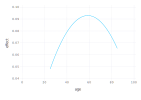

In [86]:
plot(result_df, x = :age, y = :effect, Geom.line)

In [124]:
MPs_df = CSV.read("../../data/PREDICTION/MPs.csv", DataFrame, missingstring=["NA"])

,surname,firstname,party,ln.gross,ln.net,yob,yod,margin.pre,region,margin
,String15,String15,String7,Float64,Float64,Int64?,Int64,Float64?,String31,Float64
1,Llewellyn,David,tory,12.1359,12.1359,1916,1992,missing,Wales,0.056904
2,Morris,Claud,labour,12.4481,12.4481,1920,2000,missing,South West England,-0.0497383
3,Walker,George,tory,12.4284,10.349,1914,1999,-0.0571682,North East England,-0.0415887
4,Walker,Harold,labour,11.9185,12.395,1927,2003,-0.0725089,Yorkshire and Humberside,0.0232952
5,Waring,John,tory,13.5202,13.5202,1923,1989,-0.26969,Greater London,-0.230006
6,Brown,Ronald,labour,12.4605,9.63184,1921,2002,0.340959,Greater London,0.36797
7,Pine,Leslie,tory,11.9858,11.9858,1907,1987,-0.210567,South West England,-0.0726411
8,Pink,Bonner,tory,11.634,11.634,1912,1984,0.273772,South East England,0.212945
9,Webster,Reginald,tory,12.5163,12.51,1905,1998,-0.169647,North West England,-0.0144659


In [125]:
describe(MPs_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,Type
1,surname,,,Adkins,,,,Youngson,379,0,Llewellyn,Thompson,String15
2,firstname,,,Alan,,,,Xenia,161,0,David,Donald,String15
3,party,,,labour,,,,tory,2,0,tory,tory,String7
4,ln.gross,12.619,1.06902,8.43317,12.1352,12.4605,13.0978,16.3115,,0,12.1359,12.5533,Float64
5,ln.net,12.4391,1.27038,6.98118,11.9074,12.403,13.0792,16.3045,,0,12.1359,6.98118,Float64
6,yob,1918.59,9.68136,1890,1912.0,1919.0,1926.0,1945,,2,1916,1931,"Union{Missing, Int64}"
7,yod,1995.35,6.40012,1984,1990.0,1996.0,2001.0,2005,,0,1992,2005,Int64
8,margin.pre,-0.0736125,0.143595,-0.548969,-0.162935,-0.0792726,-0.0158894,0.712098,,83,missing,-0.271667,"Union{Missing, Float64}"
9,region,,,,,,,Yorkshire and Humberside,12,0,Wales,Yorkshire and Humberside,String31


In [126]:
rename!(MPs_df, "ln.net" => :ln_net, "ln.gross" => :ln_gross, "margin.pre" => :margin_pre)

,surname,firstname,party,ln_gross,ln_net,yob,yod,margin_pre,region,margin
,String15,String15,String7,Float64,Float64,Int64?,Int64,Float64?,String31,Float64
1,Llewellyn,David,tory,12.1359,12.1359,1916,1992,missing,Wales,0.056904
2,Morris,Claud,labour,12.4481,12.4481,1920,2000,missing,South West England,-0.0497383
3,Walker,George,tory,12.4284,10.349,1914,1999,-0.0571682,North East England,-0.0415887
4,Walker,Harold,labour,11.9185,12.395,1927,2003,-0.0725089,Yorkshire and Humberside,0.0232952
5,Waring,John,tory,13.5202,13.5202,1923,1989,-0.26969,Greater London,-0.230006
6,Brown,Ronald,labour,12.4605,9.63184,1921,2002,0.340959,Greater London,0.36797
7,Pine,Leslie,tory,11.9858,11.9858,1907,1987,-0.210567,South West England,-0.0726411
8,Pink,Bonner,tory,11.634,11.634,1912,1984,0.273772,South East England,0.212945
9,Webster,Reginald,tory,12.5163,12.51,1905,1998,-0.169647,North West England,-0.0144659


In [127]:
labour_p_df = @rsubset(MPs_df, :party == "labour", :margin >= 0)
labour_n_df = @rsubset(MPs_df, :party == "labour", :margin < 0)
tory_p_df = @rsubset(MPs_df, :party == "tory", :margin >= 0)
tory_n_df = @rsubset(MPs_df, :party == "tory", :margin < 0)

,surname,firstname,party,ln_gross,ln_net,yob,yod,margin_pre,region,margin
,String15,String15,String7,Float64,Float64,Int64?,Int64,Float64?,String31,Float64
1,Walker,George,tory,12.4284,10.349,1914,1999,-0.0571682,North East England,-0.0415887
2,Waring,John,tory,13.5202,13.5202,1923,1989,-0.26969,Greater London,-0.230006
3,Pine,Leslie,tory,11.9858,11.9858,1907,1987,-0.210567,South West England,-0.0726411
4,Webster,Reginald,tory,12.5163,12.51,1905,1998,-0.169647,North West England,-0.0144659
5,Underhill,Michael,tory,12.556,12.556,1918,1987,-0.143719,Greater London,-0.0548863
6,Roberts,Shelagh,tory,13.6942,13.6942,1924,1992,-0.231121,Wales,-0.301682
7,Coles,Gerald,tory,11.4688,11.4437,1933,2002,-0.0886611,North East England,-0.0734013
8,Greene,Royden,tory,12.4284,11.8306,1917,1999,-0.257032,East Midlands,-0.0882938
9,McWhirter,Norris,tory,15.0326,15.0312,1925,2004,-0.0656256,South East England,-0.0334585


In [128]:
model_labour_p = lm(@formula(ln_net ~ margin), labour_p_df)
model_labour_n = lm(@formula(ln_net ~ margin), labour_n_df)
model_tory_p = lm(@formula(ln_net ~ margin), tory_p_df)
model_tory_n = lm(@formula(ln_net ~ margin), tory_n_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ln_net ~ 1 + margin

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  12.5381     0.214179  58.54    <1e-88   12.114     12.9622
margin        1.49112    1.29141    1.15    0.2506   -1.06601    4.04825
────────────────────────────────────────────────────────────────────────

In [129]:
exp(coef(model_labour_p)[1]) - exp(coef(model_labour_n)[1])

-67900.34443963718

In [130]:
exp(coef(model_tory_p)[1]) - exp(coef(model_tory_n)[1])

255050.92314682627

In [131]:
model_tory_pre_p = lm(@formula(margin_pre ~ margin), tory_p_df)
model_tory_pre_n = lm(@formula(margin_pre ~ margin), tory_n_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

margin_pre ~ 1 + margin

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0422291   0.0113981  -3.70    0.0003  -0.0648269  -0.0196313
margin        0.845336    0.0668818  12.64    <1e-22   0.712737    0.977936
────────────────────────────────────────────────────────────────────────────

In [133]:
exp(coef(model_tory_pre_p)[1]) - exp(coef(model_tory_pre_n)[1])

-0.01640034376520505